# Predict home prices using XGBoost with factors like income, schools, hospitals, and crime rates.

In [62]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import pickle

# To display all the coloumn of dataset
pd.pandas.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('kc_house_data.csv', parse_dates=['date'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
print(f"No. of features present : {len(df.columns)}")

No. of features present : 21


## Exploratory Data Analysis (EDA)

In [6]:
df.isnull().sum() # There is no null value present

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
df.duplicated().any() # There is no duplicate value

False

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [9]:
# Droping the irrelavent features
train_X = df.drop(['id', 'date', 'price'], axis=1)
y = df['price']

In [10]:
X = train_X.join(y)
X.sample()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
2038,3,2.5,1530,2890,2.0,0,0,3,7,1530,0,2001,0,98108,47.5434,-122.293,1540,2890,250000.0


In [11]:
int_ = (X.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (X.dtypes == 'float64')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Integer variables: 14
Float variables: 5


In [12]:
(X.describe()).round(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46,540088.14
std,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18,367127.20
min,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,75000.00
25%,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00,321950.00
50%,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00,450000.00
75%,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00,645000.00
max,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00,7700000.00


<Axes: >

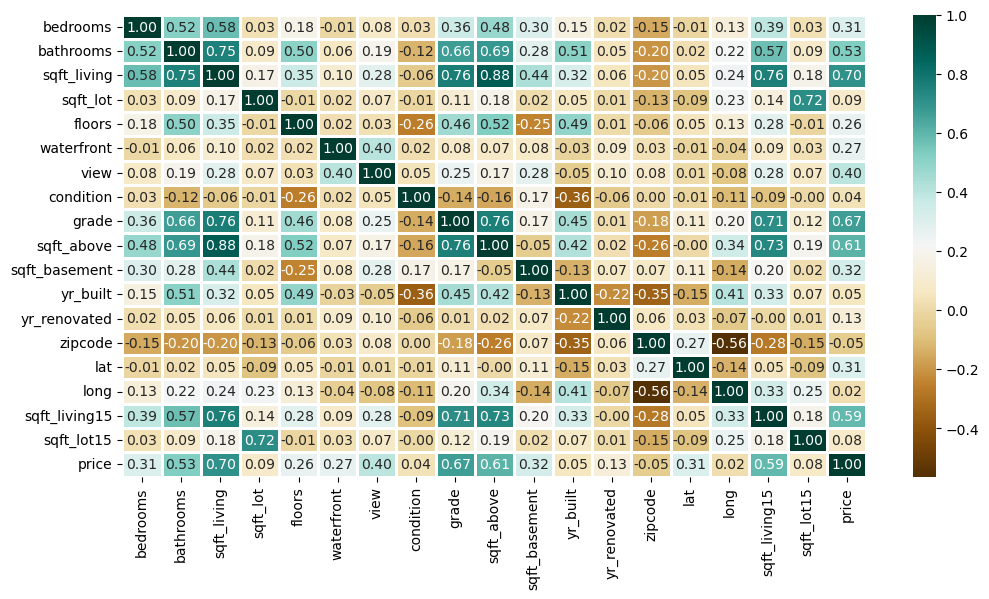

In [13]:
# Correlation Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(X.corr(), cmap = 'BrBG', fmt = '.2f', linewidths = 2, annot = True)

In [14]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_list = []  # List of fetures and their correlation value
    corr_matrix = dataset.corr()
   
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold: 
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                corr_list.append([colname, (corr_matrix.iloc[i, j]).round(2)])
    return col_corr, corr_list

In [15]:
corr_features, corr_list = correlation(X.drop('price', axis=1), 0.7)
len(set(corr_features)) # Number of features are highly correlated with each other

5

In [16]:
corr_list

[['sqft_living', 0.75],
 ['grade', 0.76],
 ['sqft_above', 0.88],
 ['sqft_above', 0.76],
 ['sqft_living15', 0.76],
 ['sqft_living15', 0.71],
 ['sqft_living15', 0.73],
 ['sqft_lot15', 0.72]]

In [17]:
corr_features

{'grade', 'sqft_above', 'sqft_living', 'sqft_living15', 'sqft_lot15'}

In [18]:
X.drop(['grade', 'sqft_above', 'sqft_living', 'sqft_living15', 'sqft_lot15'], axis=1, inplace= True)

In [19]:
X

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
0,3,1.00,5650,1.0,0,0,3,0,1955,0,98178,47.5112,-122.257,221900.0
1,3,2.25,7242,2.0,0,0,3,400,1951,1991,98125,47.7210,-122.319,538000.0
2,2,1.00,10000,1.0,0,0,3,0,1933,0,98028,47.7379,-122.233,180000.0
3,4,3.00,5000,1.0,0,0,5,910,1965,0,98136,47.5208,-122.393,604000.0
4,3,2.00,8080,1.0,0,0,3,0,1987,0,98074,47.6168,-122.045,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1131,3.0,0,0,3,0,2009,0,98103,47.6993,-122.346,360000.0
21609,4,2.50,5813,2.0,0,0,3,0,2014,0,98146,47.5107,-122.362,400000.0
21610,2,0.75,1350,2.0,0,0,3,0,2009,0,98144,47.5944,-122.299,402101.0
21611,3,2.50,2388,2.0,0,0,3,0,2004,0,98027,47.5345,-122.069,400000.0


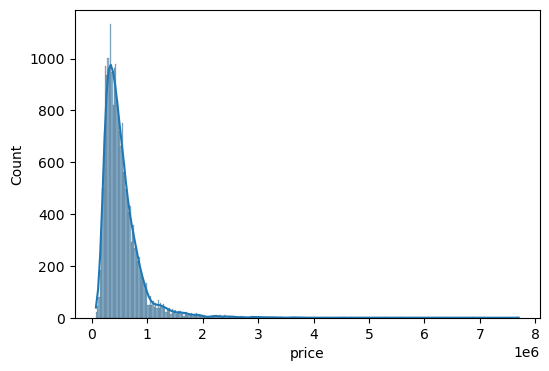

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(data=X, x='price', kde=True)
plt.show()

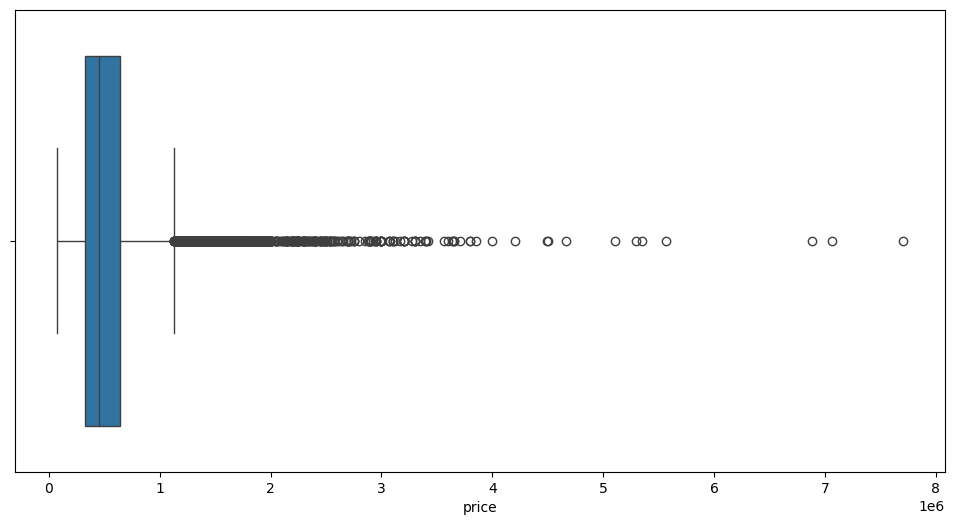

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=X['price'])
plt.show()

In [22]:
# Removing the outliers
Q1 = X['price'].quantile(0.25)
Q3 = X['price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (X['price'] >= Q1 - 1.5 * IQR) & (X['price'] <= Q3 + 1.5 *IQR)
X = X.loc[filter]  

In [23]:
X

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
0,3,1.00,5650,1.0,0,0,3,0,1955,0,98178,47.5112,-122.257,221900.0
1,3,2.25,7242,2.0,0,0,3,400,1951,1991,98125,47.7210,-122.319,538000.0
2,2,1.00,10000,1.0,0,0,3,0,1933,0,98028,47.7379,-122.233,180000.0
3,4,3.00,5000,1.0,0,0,5,910,1965,0,98136,47.5208,-122.393,604000.0
4,3,2.00,8080,1.0,0,0,3,0,1987,0,98074,47.6168,-122.045,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1131,3.0,0,0,3,0,2009,0,98103,47.6993,-122.346,360000.0
21609,4,2.50,5813,2.0,0,0,3,0,2014,0,98146,47.5107,-122.362,400000.0
21610,2,0.75,1350,2.0,0,0,3,0,2009,0,98144,47.5944,-122.299,402101.0
21611,3,2.50,2388,2.0,0,0,3,0,2004,0,98027,47.5345,-122.069,400000.0


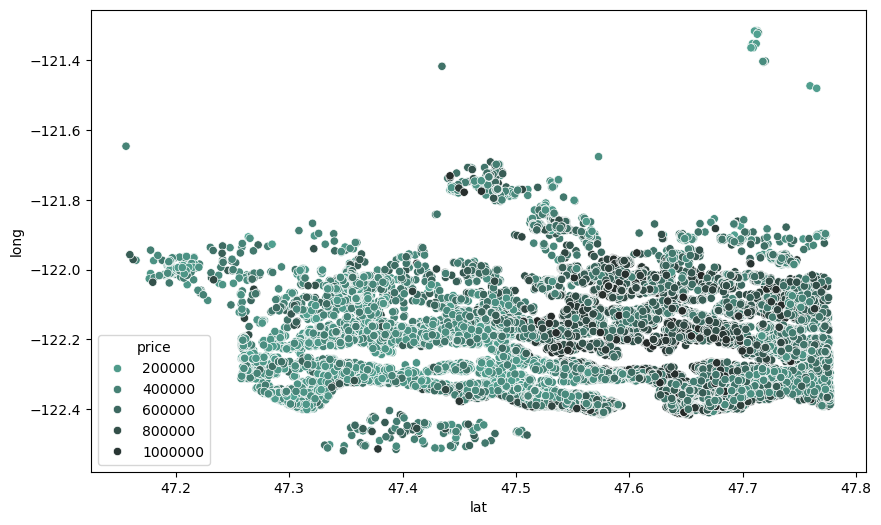

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'lat', y = 'long', data = X, hue = 'price', palette='dark:#5A9_r')
plt.show()

In [25]:
X.bedrooms.value_counts()

3     9597
4     6308
2     2736
5     1339
6      230
1      198
7       30
0       12
8        9
9        4
10       2
11       1
33       1
Name: bedrooms, dtype: int64

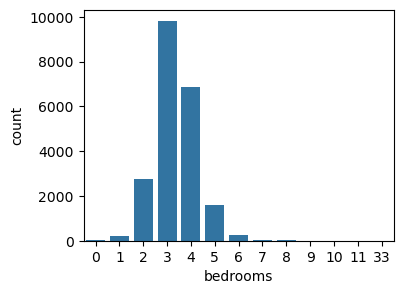

In [26]:
plt.figure(figsize=(4,3))
sns.countplot(data=df, x='bedrooms')
plt.show()

In [27]:
X.bathrooms.value_counts()

2.50    5199
1.00    3850
1.75    3016
2.25    1958
2.00    1909
1.50    1436
2.75    1107
3.00     667
3.50     544
3.25     428
3.75      84
4.00      76
0.75      72
4.50      51
4.25      29
0.00       9
5.00       8
1.25       7
4.75       5
0.50       4
5.25       3
6.75       1
7.50       1
5.50       1
5.75       1
6.00       1
Name: bathrooms, dtype: int64

In [28]:
X['bathrooms'] = X['bathrooms'].apply(lambda x: math.ceil(x)).astype('int64') # consideringthe ceil value for bathroom

C:\Users\91907\AppData\Local\Temp\ipykernel_24304\2378507848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['bathrooms'] = X['bathrooms'].apply(lambda x: math.ceil(x)).astype('int64') # consideringthe ceil value for bathroom


In [29]:
X['bathrooms'].value_counts()

3    8931
2    6368
1    3926
4    1132
5      93
0       9
6       6
7       1
8       1
Name: bathrooms, dtype: int64

In [30]:
X.waterfront.value_counts() # 0 = No WaterFront, 1 = Yes WaterFront

0    20406
1       61
Name: waterfront, dtype: int64

In [31]:
X.condition.value_counts() 

3    13284
4     5423
5     1561
2      170
1       29
Name: condition, dtype: int64

In [32]:
X.view.value_counts()

0    18884
2      810
3      350
1      276
4      147
Name: view, dtype: int64

In [33]:
X.corr()['price'].sort_values()

zipcode         -0.018511
condition        0.038275
waterfront       0.051449
yr_built         0.061144
long             0.070863
yr_renovated     0.083601
sqft_lot         0.093950
sqft_basement    0.235701
view             0.238268
floors           0.273987
bedrooms         0.296956
lat              0.430762
bathrooms        0.437911
price            1.000000
Name: price, dtype: float64

In [34]:
# Zipcode is droped due to it has a correlation close to 0. This means that the feature does not have a useful relationship to the target, and won't help with any prediction.
X.drop('zipcode', axis=1, inplace=True)

C:\Users\91907\AppData\Local\Temp\ipykernel_24304\3102250608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('zipcode', axis=1, inplace=True)


<Axes: xlabel='price', ylabel='sqft_living'>

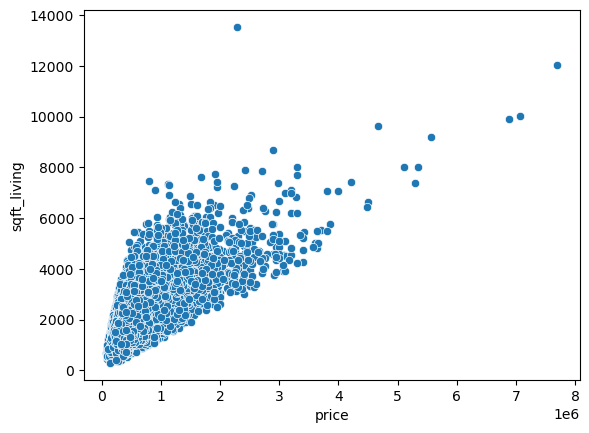

In [35]:
sns.scatterplot(x='price', y='sqft_living', data=df)

<Axes: xlabel='price', ylabel='sqft_above'>

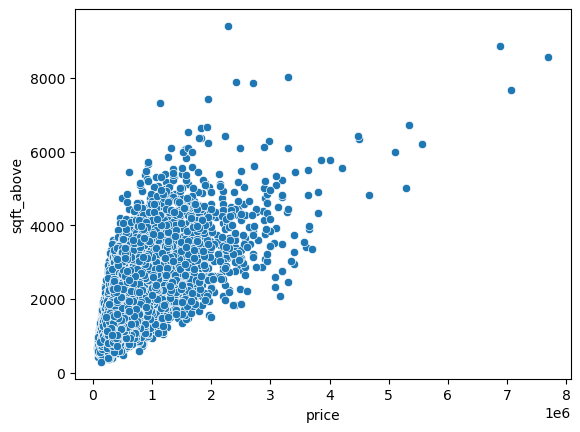

In [36]:
sns.scatterplot(x='price', y='sqft_above', data=df)

In [37]:
def change_yr_renovated(x):
    if x == 0:
        return 0
    return 1

X['is_renovated'] = X['yr_renovated'].apply(change_yr_renovated)

X.drop('yr_renovated', axis=1, inplace=True)

C:\Users\91907\AppData\Local\Temp\ipykernel_24304\427225696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_renovated'] = X['yr_renovated'].apply(change_yr_renovated)
C:\Users\91907\AppData\Local\Temp\ipykernel_24304\427225696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('yr_renovated', axis=1, inplace=True)


In [38]:
df.yr_built.unique()

array([1955, 1951, 1933, 1965, 1987, 2001, 1995, 1963, 1960, 2003, 1942,
       1927, 1977, 1900, 1979, 1994, 1916, 1921, 1969, 1947, 1968, 1985,
       1941, 1915, 1909, 1948, 2005, 1929, 1981, 1930, 1904, 1996, 2000,
       1984, 2014, 1922, 1959, 1966, 1953, 1950, 2008, 1991, 1954, 1973,
       1925, 1989, 1972, 1986, 1956, 2002, 1992, 1964, 1952, 1961, 2006,
       1988, 1962, 1939, 1946, 1967, 1975, 1980, 1910, 1983, 1978, 1905,
       1971, 2010, 1945, 1924, 1990, 1914, 1926, 2004, 1923, 2007, 1976,
       1949, 1999, 1901, 1993, 1920, 1997, 1943, 1957, 1940, 1918, 1928,
       1974, 1911, 1936, 1937, 1982, 1908, 1931, 1998, 1913, 2013, 1907,
       1958, 2012, 1912, 2011, 1917, 1932, 1944, 1902, 2009, 1903, 1970,
       2015, 1934, 1938, 1919, 1906, 1935], dtype=int64)

In [39]:
X['floors'] = X['floors'].apply(lambda x : math.ceil(x)).astype('int64')

C:\Users\91907\AppData\Local\Temp\ipykernel_24304\1457562655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['floors'] = X['floors'].apply(lambda x : math.ceil(x)).astype('int64')


In [40]:
X

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,price,is_renovated
0,3,1,5650,1,0,0,3,0,1955,47.5112,-122.257,221900.0,0
1,3,3,7242,2,0,0,3,400,1951,47.7210,-122.319,538000.0,1
2,2,1,10000,1,0,0,3,0,1933,47.7379,-122.233,180000.0,0
3,4,3,5000,1,0,0,5,910,1965,47.5208,-122.393,604000.0,0
4,3,2,8080,1,0,0,3,0,1987,47.6168,-122.045,510000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,3,1131,3,0,0,3,0,2009,47.6993,-122.346,360000.0,0
21609,4,3,5813,2,0,0,3,0,2014,47.5107,-122.362,400000.0,0
21610,2,1,1350,2,0,0,3,0,2009,47.5944,-122.299,402101.0,0
21611,3,3,2388,2,0,0,3,0,2004,47.5345,-122.069,400000.0,0


In [41]:
import pickle
pickle.dump(X.to_dict(), open('df_dict.pkl','wb'))

### Spliting the dataset into train and test set 

In [42]:
from sklearn.model_selection import train_test_split

X_ = X.drop(['price'], axis=1)
y = X['price']

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=0)

### Feature Scaling

In [43]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [63]:
file_path = 'standardScaler_model.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    pickle.dump(sc, f)

### Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [45]:
y_pred = reg.predict(X_test)

In [46]:
from sklearn import metrics

print(f" mean absolute error is  ==>  {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"\n R2 score of model predict is  ==>  {metrics.r2_score(y_test, y_pred)}")
print(f"\n mean of dataset ==>  {X['price'].mean()}")
print(f"\n standard deviation of dataset  ==>  {X['price'].std()} ")

 mean absolute error is  ==>  113530.10465467765

 R2 score of model predict is  ==>  0.4930301498623034

 mean of dataset ==>  476984.55943714274

 standard deviation of dataset  ==>  208371.26167027562 


### XGBOOST

In [47]:
from xgboost import XGBRegressor

xg = XGBRegressor(objective ='reg:linear', 
                  n_estimators = 1000, 
                  learning_rate = 0.05, 
                  max_depth = 6, 
                  min_child_weight = 1, 
                  subsample = 0.8, 
                  colsample_bytree = 0.8, 
                  gamma = 0.2, 
                  reg_alpha = 0, 
                  reg_lambda = 1,
                  eval_metric = 'rmse',
                  nthread=4,
                  scale_pos_weight=1,
                  seed = 123)

xg.fit(X_train, y_train)

c:\Users\91907\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [09:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
             num_parallel_tree=None, ...)

In [48]:
y_pred = xg.predict(X_test)

In [49]:
from sklearn import metrics

print(f" mean absolute error is  ==>  {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"\n R2 score of model predict is  ==>  {metrics.r2_score(y_test, y_pred)}")
print(f"\n mean of dataset ==>  {X['price'].mean()}")
print(f"\n standard deviation of dataset  ==>  {X['price'].std()} ")

 mean absolute error is  ==>  61286.99891037188

 R2 score of model predict is  ==>  0.8301340107992672

 mean of dataset ==>  476984.55943714274

 standard deviation of dataset  ==>  208371.26167027562 


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

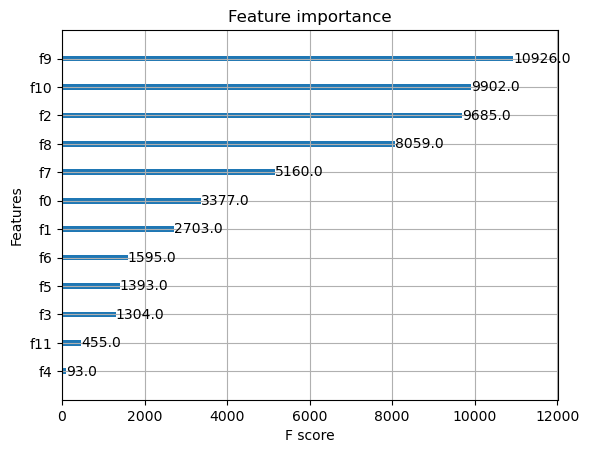

In [50]:
import xgboost as xgb

xgb.plot_importance(xg)

#### Feature importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

- f0 : bedrooms	
- f1 : bathrooms  
- f2 : sqft_lot	 
- f3 : floors	
- f4 : waterfront	 
- f5 : view   
- f6 : condition	
- f7 : sqft_basement	
- f8 : yr_built	
- f9 : lat	
- f10 : long  
- f11 : is_renovated

In [51]:
file_path = 'xgboost_model.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    pickle.dump(xg, f)

In [52]:
import pickle
file_path = 'xgboost_model.pkl'

with open(file_path, 'rb') as f:
    xg_loaded = pickle.load(f)

In [56]:
X

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,price,is_renovated
0,3,1,5650,1,0,0,3,0,1955,47.5112,-122.257,221900.0,0
1,3,3,7242,2,0,0,3,400,1951,47.7210,-122.319,538000.0,1
2,2,1,10000,1,0,0,3,0,1933,47.7379,-122.233,180000.0,0
3,4,3,5000,1,0,0,5,910,1965,47.5208,-122.393,604000.0,0
4,3,2,8080,1,0,0,3,0,1987,47.6168,-122.045,510000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,3,1131,3,0,0,3,0,2009,47.6993,-122.346,360000.0,0
21609,4,3,5813,2,0,0,3,0,2014,47.5107,-122.362,400000.0,0
21610,2,1,1350,2,0,0,3,0,2009,47.5944,-122.299,402101.0,0
21611,3,3,2388,2,0,0,3,0,2004,47.5345,-122.069,400000.0,0


In [61]:
data = {
    'bedrooms': [2],
    'bathrooms': [1],
    'sqft_lot': [1076],
    'floors': [2],
    'waterfront': [0],
    'view': [0],
    'condition': [3],
    'sqft_basement': [0],
    'yr_built': [2008],
    'lat': [47.5941],
    'long': [-122.299],
    'is_renovated': [0]
}

df_new = pd.DataFrame(data)
df_new = sc.transform(df_new)

y_pred_1 = xg_loaded.predict(df_new)
print(f'The predicted price is : {y_pred_1[0]}')

The predicted price is : 311607.21875
